# Table of Contents:
* [0 -Importing Libraries](#0)
* [1 - Read in df](#1)
* [2 - SIR](#2)
* [3 - Descriptive Facts](#3)
* [4 - Prepare the dfset (change in turnout)](#4)
* [5 - Regressions](#5)

# 0) Imports <a class="anchor" id="0"></a>

In [30]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ast  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# 1) Read in df <a class="anchor" id="1"></a>

In [2]:
txt_file = 'medium.txt'

In [3]:
# Initialize an empty list to store the df
df = []

# Define keys based on the train_train_train_train_train_dfset format
keys = ['#*', '#@', '#t', '#c', '#index', '#%', '#!']

# Open the file and read the contents
with open(txt_file, 'r', encoding='ISO-8859-1') as file:
    current_paper = {}
    for line in file:
        line = line.strip()
        if line.startswith('#*'):
            # New paper starts; save the previous one if it exists
            if current_paper:
                df.append(current_paper)
                current_paper = {}
            current_paper['Title'] = line[2:].strip()
        elif line.startswith('#@'):
            current_paper['Authors'] = line[2:].strip()
        elif line.startswith('#t'):
            current_paper['Year'] = line[2:].strip()
        elif line.startswith('#c'):
            current_paper['Venue'] = line[2:].strip()
        elif line.startswith('#index'):
            current_paper['Index ID'] = line[6:].strip()
        elif line.startswith('#%'):
            if 'References' not in current_paper:
                current_paper['References'] = []
            current_paper['References'].append(line[2:].strip())
        elif line.startswith('#!'):
            current_paper['Abstract'] = line[2:].strip()
        elif line.isdigit() and current_paper:  # Handle end of current paper
            df.append(current_paper)
            current_paper = {}
    # Add the last paper
    if current_paper:
        df.append(current_paper)

# Convert list of dicts to dfFrame
df = pd.DataFrame(df)

# Replacing missing keys with None which becomes NaN in dfFrame
for key in ['Title', 'Authors', 'Year', 'Venue', 'Index ID', 'References', 'Abstract']:
    if key not in df.columns:
        df[key] = None

In [4]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df[df['Year']>1930 & df['Year']<2010]
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
# Apply the function to the dfFrame column
df['References'] = df['References'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else x
)

Last Cited Year (for SIR)

In [5]:
# Creating a dictionary from the dfFrame assuming 'Index ID' and 'Year' are columns in your dfFrame
year_dict = df.set_index('Index ID')['Year'].to_dict()

def get_last_cited_year(ref_ids):
    if not isinstance(ref_ids, list):
        return np.nan
    # Filter and collect years where reference IDs exist in year_dict
    years = [year_dict.get(int(ref_id)) for ref_id in ref_ids if int(ref_id) in year_dict]
    return max(years) if years else np.nan

# Apply the function to the 'References' column to compute the 'Last Cited Year'
df['Last Cited Year'] = df['References'].apply(get_last_cited_year)
df["Venue"] = df["Venue"].astype(str)
df['Venue'] = df['Venue'].replace('', np.nan)
df["References Count"] = df["References"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [6]:
# Calculate total authors
df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
unique_authors = set()
df['Authors'].apply(lambda x: unique_authors.update(x.split(',')) if x else None)
total_authors = len(unique_authors) - 1 if '' in unique_authors else len(unique_authors)

# Fill missing Venue values with "Unknown"
df['Venue'] = df['Venue'].fillna("Unknown")

In [10]:
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')

# Convert 'References' from string representation of list to actual list
def safe_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []  # Return an empty list if there's any error

df['References'] = df['References'].apply(safe_eval)

# Creating a dictionary of publication years for quick lookup
publication_years = df.set_index('Index ID')['Year'].to_dict()

# Function to count citations within three years
def count_citations_within_3_years(row):
    if isinstance(row['References'], list):  # Ensure that the data is list
        citation_years = [publication_years.get(int(ref)) for ref in row['References'] if publication_years.get(int(ref)) is not None]
        return sum((year is not None and (row['Year'] <= year <= row['Year'] + 3)) for year in citation_years)
    return 0  # Return 0 if References is not a list

# Apply the function
df['citation_count_within_3_years'] = df.apply(count_citations_within_3_years, axis=1)

In [18]:
# Define the high-impact venues
high_impact_venues = [
    "Nature", 
    "Science", 
    "Advances in Neural Information Processing Systems 5", 
    "[NIPS Conference]"
]

# Function to check if the venue is high-impact
def is_high_impact(venue):
    if any(high in venue for high in high_impact_venues):
        return True
    if "International Conference on Machine Learning" in venue:
        return True
    return False

high_impact_threshold = 10  # From online

# Classify papers based on the defined criteria
df['CITING'] = df['References'].notna()
df['ARCHIVED'] = df.apply(lambda x: (df['Year'].max() - x['Last Cited Year'] >= 5) if pd.notna(x['Last Cited Year']) else False, axis=1)
df['EXPOSED'] = df['Venue'].apply(is_high_impact) | (df['citation_count_within_3_years'] >= high_impact_threshold)
df['UNLINKED'] = df['CITING'] & (np.random.rand(len(df)) < 0.05)
df["PENDING"] = False
# PENDING (P) category cannot be directly modeled from the df as it pertains to future papers

KeyboardInterrupt: 

In [13]:
print(len(df[df['CITING'] == True]), len(df[df['ARCHIVED'] == True]), len(df[df['EXPOSED'] == True]), 
      len(df[df['UNLINKED'] == True]), len(df[df['PENDING'] == True]))

312949 238285 22750 15800 0


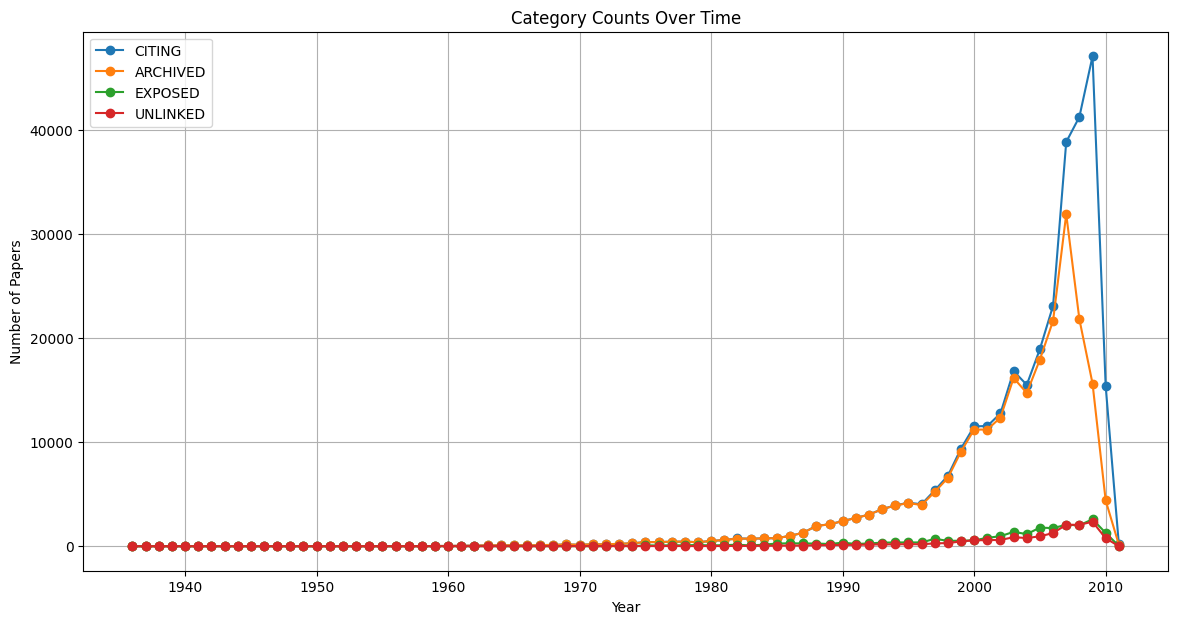

In [15]:
# Group by year and count each category
yearly_data = df.groupby('Year').agg({
    'CITING': 'sum',
    'ARCHIVED': 'sum',
    'EXPOSED': 'sum',
    'UNLINKED': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(yearly_data['Year'], yearly_data['CITING'], label='CITING', marker='o')
plt.plot(yearly_data['Year'], yearly_data['ARCHIVED'], label='ARCHIVED', marker='o')
plt.plot(yearly_data['Year'], yearly_data['EXPOSED'], label='EXPOSED', marker='o')
plt.plot(yearly_data['Year'], yearly_data['UNLINKED'], label='UNLINKED', marker='o')

plt.title('Category Counts Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.legend()
plt.grid(True)
plt.show()

# 2) PACEU model <a class="anchor" id="2"></a>

In [63]:
# Reset index
df = df.sample(frac=1).reset_index(drop=True)

In [72]:
min_year = 2000
test_year = 2007
max_year = 2009

In [73]:
# Time-based split
train_df = df[(df['Year'] <= test_year) & (df['Year'] > min_year)]
test_df = df[df['Year'] > test_year]

## 2.1) Define intial conditions

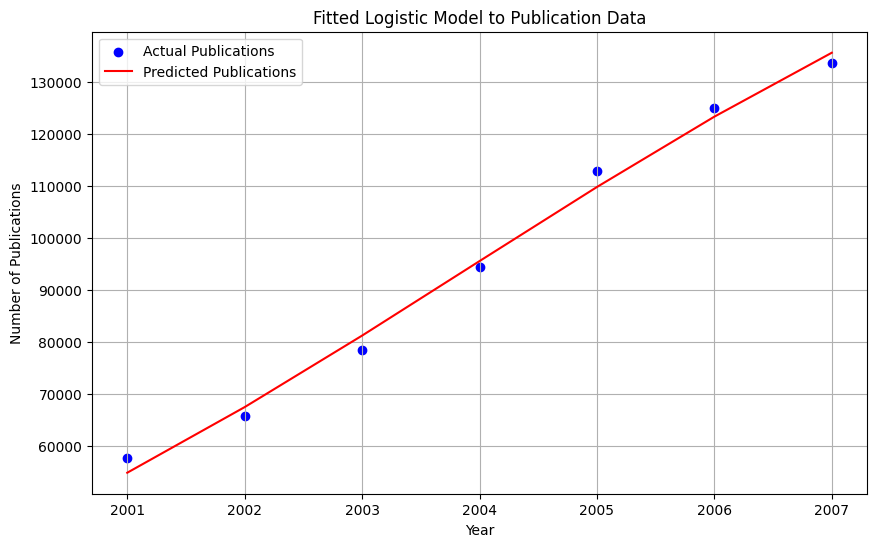

In [74]:
# Count publications per year within the training set
year_counts = train_df['Year'].value_counts().sort_index()

# Prepare data for the model fitting
x_data = year_counts.index.values
y_data = year_counts.values

# Initial guesses for parameters
P0_initial = y_data[0]  # Initial population size (publications in the first year of training data)
K_initial = y_data[-1] * 1.5  # Assume carrying capacity is a bit higher than the last observed data point
r_initial = 0.1  # Initial guess for the growth rate

# Logistic growth model function
def logistic_model(x, K, P0, r):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * (x - x.min())))

# Fit the logistic model to the training data
params, cov = curve_fit(logistic_model, x_data, y_data, p0=[K_initial, P0_initial, r_initial], maxfev=10000)
K, P0, r = params

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Actual Publications')
plt.plot(x_data, logistic_model(x_data, *params), color='red', label='Predicted Publications')
plt.title('Fitted Logistic Model to Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Logistic growth function
def logistic_growth(t, P):
    return r * P * (1 - P / K)

# Simulation period (extend beyond the dataset to predict future)
simulation_years = np.arange(min_year, max_year)  # From year 2000 to 2029

# Solve the logistic growth model
solution = solve_ivp(logistic_growth, [simulation_years.min(), simulation_years.max()], [P0], t_eval=simulation_years)

In [75]:
# Prepare for simulation of the PACEU model
def citation_model(y, t, beta, gamma):
    P, E, C, A = y
    dE_dt = beta * P  # Move from PENDING to EXPOSED
    dC_dt = beta * E - gamma * C  # Move from EXPOSED to CITING and from CITING to ARCHIVED
    dA_dt = gamma * C  # Move from CITING to ARCHIVED
    dP_dt = -beta * P  # Papers leaving PENDING
    return [dP_dt, dE_dt, dC_dt, dA_dt]

In [76]:
def calculate_parameters(train_df, min_year):
    train_df = train_df[train_df['UNLINKED'] == False]  # Exclude unlinked papers
    lambda_vals, beta_vals, gamma_vals = [], [], []
    # Filter dataset from the minimum year
    train_df = train_df[train_df['Year'] >= min_year]
    for year in range(int(train_df['Year'].min()), int(train_df['Year'].max())):
        exposed_previous_year = train_df[train_df['Year'] == year - 1]['EXPOSED'].sum()
        citing_previous_year = train_df[train_df['Year'] == year - 1]['CITING'].sum()

        new_exposed = train_df[train_df['Year'] == year]['EXPOSED'].sum() - exposed_previous_year
        new_citing = train_df[train_df['Year'] == year]['CITING'].sum() - citing_previous_year
        new_archived = train_df[train_df['Year'] == year]['ARCHIVED'].sum() - train_df[train_df['Year'] == year - 1]['ARCHIVED'].sum()

        total_papers = train_df[train_df['Year'] == year - 1].shape[0]

        if total_papers > 0:
            lambda_vals.append(new_exposed / total_papers)
        if exposed_previous_year > 0:
            beta_vals.append(new_citing / exposed_previous_year)
        if citing_previous_year > 0:
            gamma_vals.append(new_archived / citing_previous_year)

    lambda_ = np.mean(lambda_vals)
    beta = np.mean(beta_vals)
    gamma = np.mean(gamma_vals)

    return lambda_, beta, gamma

lambda_, beta, gamma = calculate_parameters(train_df, min_year)
params = (lambda_, beta, gamma)
print(f"Parameters: {params}")

Parameters: (0.002488515216365305, 1.9033116110744834, 0.1418322450038068)


In [77]:
# # Param stablization
# def calculate_parameters(train_df):
#     lambda_vals, beta_vals, gamma_vals = [], [], []
#     years = range(int(train_df['Year'].min()), int(train_df['Year'].max()) + 1)
    
#     for year in years:
#         exposed_previous_year = train_df[train_df['Year'] == year - 1]['EXPOSED'].sum()
#         citing_previous_year = train_df[train_df['Year'] == year - 1]['CITING'].sum()

#         new_exposed = train_df[train_df['Year'] == year]['EXPOSED'].sum() - exposed_previous_year
#         new_citing = train_df[train_df['Year'] == year]['CITING'].sum() - citing_previous_year
#         new_archived = train_df[train_df['Year'] == year]['ARCHIVED'].sum() - train_df[train_df['Year'] == year - 1]['ARCHIVED'].sum()

#         total_papers = train_df[train_df['Year'] == year - 1].shape[0]

#         if total_papers > 0:
#             lambda_vals.append(new_exposed / total_papers)
#         if exposed_previous_year > 0:
#             beta_vals.append(new_citing / exposed_previous_year)
#         if citing_previous_year > 0:
#             gamma_vals.append(new_archived / citing_previous_year)

#     # Simple moving average for parameter smoothing
#     window_size = 3  # Adjust window size as needed
#     lambda_ = np.mean(lambda_vals[-window_size:])
#     beta = np.mean(beta_vals[-window_size:])
#     gamma = np.mean(gamma_vals[-window_size:])

#     return lambda_, beta, gamma

## 2.2) 

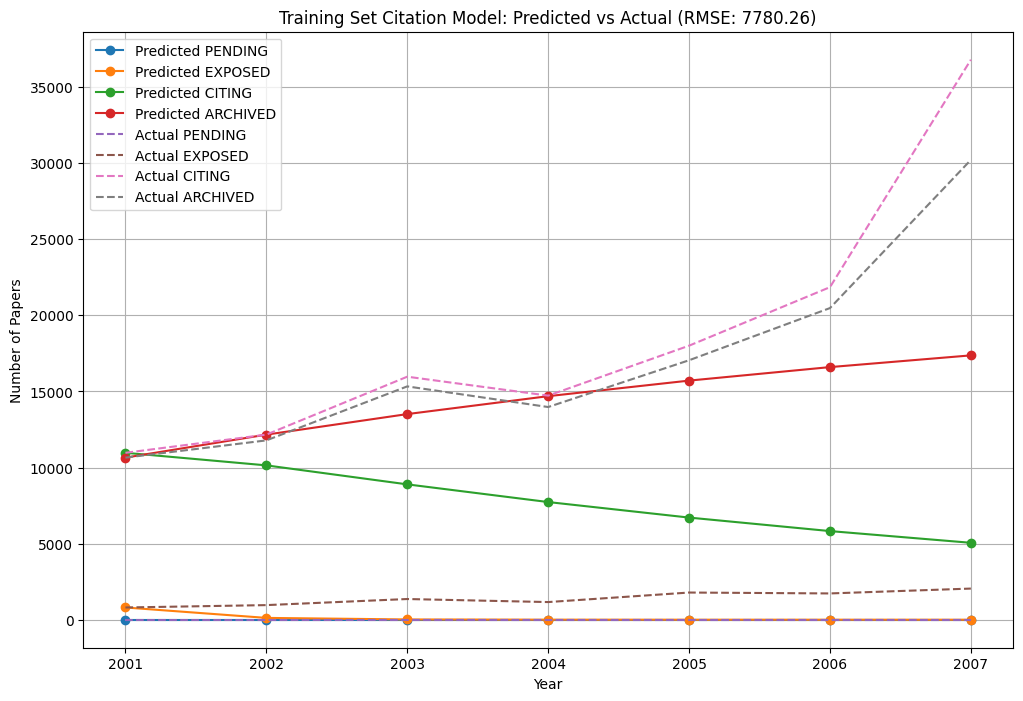

In [78]:
def run_simulation_and_plot(df, min_year, params, title):
    # Filter dataset from the minimum year
    df = df[df['Year'] >= min_year]
    df = df[df['UNLINKED'] == False] # Exclude unlinked papers
    years = np.array(sorted(df['Year'].unique()))

    lambda_, beta, gamma = params
    Get P0 from above
    E0 = df[df['Year'] == min(years)]['EXPOSED'].sum()
    C0 = df[df['Year'] == min(years)]['CITING'].sum()
    A0 = df[df['Year'] == min(years)]['ARCHIVED'].sum()
    y0 = [P0, E0, C0, A0]

    time_points = np.linspace(min(years), max(years), num=len(years))
    # solve_ivp(citation_model, [simulation_years.min(), simulation_years.max()], [P0, E0, C0, A0], args=(beta, gamma), t_eval=simulation_years)
    results = odeint(citation_model, y0, time_points, args=params)
    actual_data = [[df[df['Year'] == year]['PENDING'].sum(),
                    df[df['Year'] == year]['EXPOSED'].sum(),
                    df[df['Year'] == year]['CITING'].sum(),
                    df[df['Year'] == year]['ARCHIVED'].sum()] for year in years]

    rmse = np.sqrt(mean_squared_error(np.array(actual_data), results))
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, results, marker='o')
    plt.plot(time_points, np.array(actual_data), linestyle='--')
    plt.title(f'{title}: Predicted vs Actual (RMSE: {rmse:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.legend(['Predicted PENDING', 'Predicted EXPOSED', 'Predicted CITING', 'Predicted ARCHIVED', 
                'Actual PENDING', 'Actual EXPOSED', 'Actual CITING', 'Actual ARCHIVED'], loc='upper left')
    plt.grid(True)
    plt.show()

    return rmse

# Update calls to simulation function
train_rmse = run_simulation_and_plot(train_df, min_year, params, 'Training Set Citation Model')

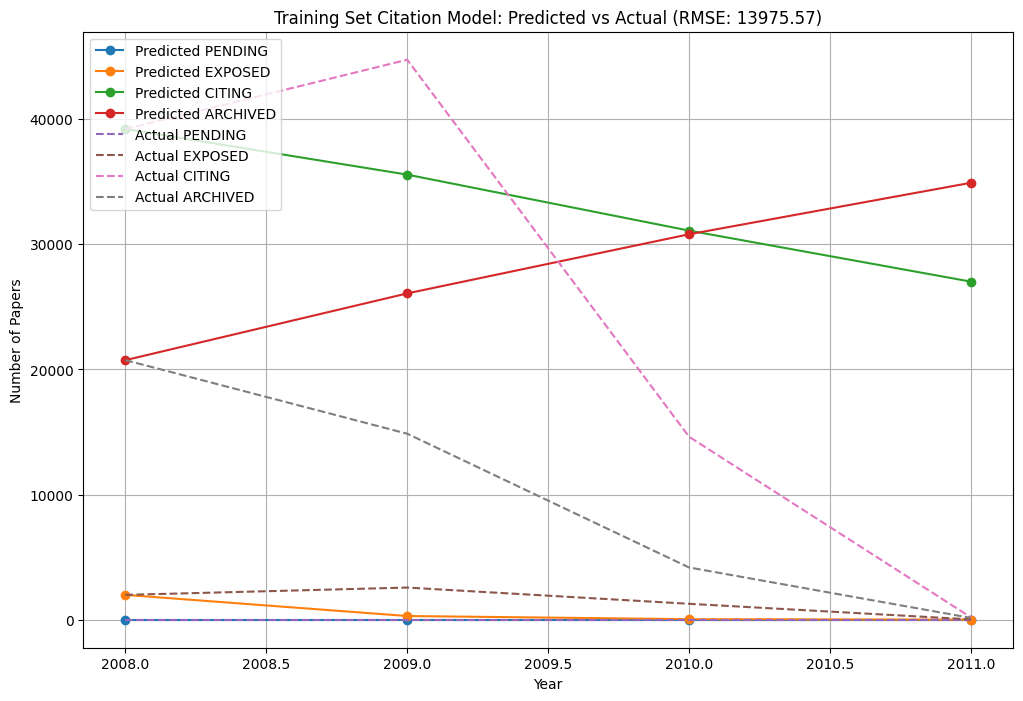

In [79]:
# Update calls to simulation function
test_rmse = run_simulation_and_plot(test_df, min_year, params, 'Training Set Citation Model')